In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, LinExpr, quicksum
import collections

# DCNDP 2

In [2]:
# Def to get a graph in file format .edgelist or .gml, given a file-path
def get_graph(path: str):
    if path.endswith('.edgelist'):
        return nx.read_edgelist(path=path, nodetype=int)
    else:
        return nx.read_gml(path=path, label='id')

In [3]:
G = get_graph('data/Real_networks/attiro.edgelist')

In [4]:
N = G.number_of_nodes()
L=nx.diameter(G)
C = int(0.1 * N)

In [5]:
# global variable
cut_count = 0
bound_check = 0
global bound_save

In [6]:
nx.global_efficiency(G)

0.3894116501071505

In [7]:
#define communication efficiency function (1/d -for example)
f=list()
for l in range(G.number_of_nodes()):
    f.append(1/float(l+1))

### Define the modified cut callback with the BFS implementation

In [8]:
# bfs tree generation to separate integer solution
def first_depth_k_bfs(input_graph, cost, connect, L, cut_limit, model):
    global cut_count
    roots = [n for (n, attr) in cost.items() if attr == 0]
    for root in roots:
        # keep track of all visited nodes and nodes to be checked
        visited, queue = {root}, collections.deque([root])
        # this dict keeps track of levels
        levels = {root: 0}

        # this dict keeps track of predecessors
        predecessor = {root: -1}
        cut_count = 0

        # keep looping until there are no nodes still to be checked
        while queue:
            if cut_count > cut_limit:
                break
            # pop first node from the queue
            vertex = queue.popleft()
            for neighbour in input_graph[vertex]:
                # only consider neighbors with solution=0
                if neighbour not in visited and cost[neighbour] <= 1e-5:
                    new_levels = levels[vertex] + 1
                    if new_levels == 1:  # direct neighbours of root node
                        predecessor[neighbour] = vertex
                        levels[neighbour] = new_levels
                        # mark neighbours of node as visited to avoid revisiting
                        visited.add(neighbour)
                        # add neighbours of node to queue
                        queue.append(neighbour)

                    elif new_levels in range(2, L + 1):
                        predecessor[neighbour] = vertex
                        levels[neighbour] = new_levels
                        # mark neighbours of node as visited to avoid revisiting
                        visited.add(neighbour)
                        # add neighbours of node to queue
                        queue.append(neighbour)
                        i = min([root, neighbour])
                        j = max([root, neighbour])
                        if connect[(i, j, new_levels)] < 1 - 1e-5:
                            lazy_cut_lhs = LinExpr(0)
                            lazy_cut_lhs.add(model._x_delete[root])
                            while neighbour != root:
                                lazy_cut_lhs.add(model._x_delete[neighbour])
                                nxt = predecessor[neighbour]
                                neighbour = nxt
                            model.cbLazy(lazy_cut_lhs + model._u_connect[i, j, new_levels] >= 1)
                            cut_count += 1

                    else:  # new_levels >k
                        break
            else:
                continue
            break

In [9]:
# bfs tree generation to separate fractional solution
def second_depth_k_bfs(input_graph, cost, connect, root, L, cut_limit, model):
    global cut_count
    # keep track of all visited nodes and nodes to be checked
    visited, queue = {root}, collections.deque([root])
    levels = {root: 0}  # this dict keeps track of levels
    # this dict keeps track of distance label-sum of lp-solution value of each node along the path
    dist_label = {root: cost[root]}

    # this dict keeps track of predecessors
    predecessor = {root: -1}
    cut_count = 0

    # keep looping until there are no nodes still to be checked
    while queue:
        if cut_count > cut_limit:
            return
        # pop first node from the queue
        vertex = queue.popleft()
        for neighbour in sorted(input_graph[vertex],
                                key=lambda x: input_graph.nodes[x]['LPsol']): # order the set of neighbors according to LP-relaxation solution
            # for nbr in input_graph[vertex]:
            if neighbour not in visited:  # and cost[nbr]==0:
                new_levels = levels[vertex] + 1
                if new_levels == 1:
                    predecessor[neighbour] = vertex
                    dist_label[neighbour] = dist_label[vertex] + cost[neighbour]
                    levels[neighbour] = new_levels
                    # mark neighbours of node as visited to avoid revisiting
                    visited.add(neighbour)
                    # add neighbours of node to queue
                    queue.append(neighbour)

                elif new_levels in range(2, L + 1):
                    predecessor[neighbour] = vertex
                    dist_label[neighbour] = dist_label[vertex] + cost[neighbour]
                    levels[neighbour] = new_levels
                    # mark neighbours of node as visited to avoid revisiting
                    visited.add(neighbour)
                    # add neighbours of node to queue
                    queue.append(neighbour)
                    i = min([root, neighbour])
                    j = max([root, neighbour])
                    if dist_label[neighbour] + connect[(i, j, new_levels)] < 1 - 1e-5:
                        lazy_cut_lhs = LinExpr(0)
                        lazy_cut_lhs.add(model._x_delete[root])
                        while neighbour != root:
                            lazy_cut_lhs.add(model._x_delete[neighbour])
                            nxt = predecessor[neighbour]
                            neighbour = nxt
                        model.cbLazy(lazy_cut_lhs + model._u_connect[i, j, new_levels] >= 1)
                        cut_count += 1

                else:  # new_levels >k
                    break
        else:
            continue
        break

In [10]:
def cut(model, where):
    global bound_save, bound_check
    cost = {}
    connect = {}

    if where == GRB.Callback.MIPSOL:  # if integer solution
        # get MIPSOL_OBJBDN = Current best objective bound
        bound_save = model.cbGet(GRB.callback.MIPSOL_OBJBND)
        for j in G.nodes():
            # retrieve values from the new MIP solution
            cost[j] = abs(model.cbGetSolution(model._x_delete[j]))
            for i in G.nodes():  # range(ind,j):
                if i < j:
                    for l in range(1, L + 1):
                        connect[(i, j, l)] = abs(model.cbGetSolution(model._u_connect[i, j, l]))

        first_depth_k_bfs(G, cost, connect, L, GRB.INFINITY, model)

    # if fractional solution
    elif where == GRB.Callback.MIPNODE:
        # Optimization status of current MIP node if it is OPTIMAL
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.Status.OPTIMAL:
            # get current best objective bound
            current_bound = model.cbGet(GRB.callback.MIPNODE_OBJBND)
            # get current explored node count
            node_count = int(model.cbGet(GRB.callback.MIPNODE_NODCNT))
            if bound_save == current_bound:
                bound_check += 1
                if bound_check >= 5 or node_count > 0:
                    bound_check = 0
                else:
                    for j in G.nodes():
                        cost[j] = abs(model.cbGetNodeRel(model._x_delete[j]))
                        G.nodes[j]['LPsol'] = cost[j]  # set node attributes to lp solution
                        for i in G.nodes():
                            if i < j:
                                for l in range(1, L + 1):
                                    connect[(i, j, l)] = abs(model.cbGetNodeRel(model._u_connect[i, j, l]))
                    roots = [n for (n, attr) in cost.items() if attr < 1]
                    for rt_node in roots:
                        second_depth_k_bfs(G, cost, connect, rt_node, L, 300, model)

            else:
                bound_save = current_bound
                for j in G.nodes():
                    cost[j] = abs(model.cbGetNodeRel(model._x_delete[j]))
                    G.nodes[j]['LPsol'] = cost[j]  # set node attributes to lp solution
                    for i in G.nodes():
                        if i < j:
                            for l in range(1, L + 1):
                                connect[(i, j, l)] = abs(model.cbGetNodeRel(model._u_connect[i, j, l]))
                roots = [n for (n, attr) in cost.items() if attr < 1]
                for rt_node in roots:
                    second_depth_k_bfs(G, cost, connect, rt_node, L, 300, model)

## Gurobi Model Implementation

## DCMDP_2 Model
$$
Min. \sum_{i,j \in V : i < j} (\, f(1)y^{1}_{i,j} + \sum_{l=2}^{L}f(l)(y^{l}_{i,j} - y^{l-1}_{i,j}))
\\
\\
st. \\
\sum_{r \in V(P)} x_{r} + y_{i,j} \geq 1, \quad \forall P \in P_{L}(i,j), \quad (i,j) \in V, \quad i<j
\\
y^{l-1}_{i,j} \leq y^{l}_{i,j}, \quad \forall (i,j) \in V, \quad i<j, \quad l \in {2,...,L}
\\
y^{l}_{i,j} = y^{1}_{i,j}, \quad \forall (i,j) \in E, \quad i<j, \quad l \in {2,...,L}
\\
y^{l}_{i,j} + x_i + x_j \geq 1, \quad \forall (i,j) \in E, \quad i<j, \quad l \in {2,...,L}
\\
\sum_{i \in V} x_{i} \leq B
\\
x_{i} \in {0,1}, \quad \forall v \in V
\\
\\
y_{i,j} \in {0,1}, \quad \forall (i,j) \in V, \quad i<j
$$

In [11]:
# ---------------Minimize DCNP objective-----------------
def minimize_dcnp(input_graph, L, C):
    model = Model('Minimize distance-based pairwise connectivity eg efficiency')

    # variables
    x_delete = {}
    u_connect = {}
    for j in input_graph.nodes():
        # The node degree is the number of edges adjacent to the node.
        if input_graph.degree[j] == 1:
            x_delete[j] = model.addVar(lb=0.0, ub=0.0, vtype=GRB.BINARY, name=f'x[{j}')
        else:
            x_delete[j] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=f'x[{j}')
        for i in input_graph.nodes():
            if i < j:
                for l in range(1, L + 1):
                    u_connect[i, j, l] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY,
                                                      name="u[%d,%d,%d]" % (i, j, l))

    # objective
    obj = LinExpr(0)
    for j in input_graph.nodes():
        for i in input_graph.nodes():
            if i < j:
                obj.add(f[0] * u_connect[i, j, 1])
                for l in range(1, L):
                    obj.add(f[l] * (u_connect[i, j, l + 1] - u_connect[i, j, l]))

    # constraint on number of critical nodes
    model.addConstr(sum((x_delete[j]) for j in input_graph.nodes()) <= C, name="3.24")

    # constraints on connectivity variables u

    # constraints on (i,j) in E
    for (i, j) in input_graph.edges():
        if i < j:
            model.addConstr(u_connect[i, j, 1] + x_delete[i] + x_delete[j] >= 1,
                            name="Explicitly model the non-redundant constraints and leave the rest to BFS")
            for l in range(2, L + 1):
                model.addConstr(u_connect[i, j, 1] == u_connect[i, j, l], name="3.23_2")
        else:  # that is j<i
            model.addConstr(u_connect[j, i, 1] + x_delete[j] + x_delete[i] >= 1,
                            name="Explicitly model the non-redundant constraints and leave the rest to BFS_part 2")
            for l in range(2, L + 1):
                model.addConstr(u_connect[j, i, 1] == u_connect[j, i, l], name="3.23_2")

    # constraints on (i,j) not in E
    for j in input_graph.nodes():
        for i in input_graph.nodes():
            if i not in input_graph.neighbors(j) and i < j:
                for l in range(1, L):
                    model.addConstr(u_connect[i, j, l] <= u_connect[i, j, l + 1], name="3.22")

    model.update()
    model.setObjective(obj, GRB.MINIMIZE)
    model._x_delete = x_delete
    model._u_connect = u_connect
    model.setParam(GRB.param.Cuts, 0)
    model.setParam(GRB.param.PreCrush, 1)
    model.setParam('LazyConstraints', 1)
    model.setParam('TimeLimit', 3600)
    model.optimize(cut)
    run_time = model.Runtime
    x_delete_val = model.getAttr('x', x_delete)

    critical_nodes = [i for i in x_delete_val.keys() if x_delete_val[i] >= 1 - 1e-4]

    return critical_nodes, obj.getValue(), run_time, model

### Get the result and plot the graph


In [12]:
# find the critical nodes
critical_nodes, opt_obj, run_time, model = minimize_dcnp(G, L, C)
print(f'N nodes: {G.number_of_nodes()}')
print(f'N nodes: {G.number_of_edges()}')
print(f'Diameter: {nx.diameter(G)}')
print('percentage distance-based pairwise connectivity = {:.2f}%'.format(
    2 * 100 * opt_obj / (G.number_of_nodes() * (G.number_of_nodes() - 1))))
print(f'cos: {C}')
print(f'num vars: {model.getAttr(GRB.Attr.NumVars)}')
print("critical nodes are :", critical_nodes)
print("Running Time = {:.2f} seconds".format(run_time))
print('distance-based pairwise connectivity = {:.2f} nodes'.format(opt_obj))
print(model.getAttr(GRB.Attr.ObjBound))
print(f'Status {model.getAttr(GRB.Attr.Status)}')
print(f'Work: {model.getAttr(GRB.Attr.Work)}')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-29
Set parameter Cuts to value 0
Set parameter PreCrush to value 1
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 12106 rows, 13747 columns and 24397 nonzeros
Model fingerprint: 0x5955911b
Variable types: 0 continuous, 13747 integer (13747 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 896 rows and 899 columns
Presolve time: 0.02s
Presolved: 11210 rows, 12848 columns, 22599 nonzeros
Variable types: 0 continuous, 12848 integer (12848 binary)

Root relaxation: objective 1.917450e+02, 7394 iterations, 0.37 seconds (0.69 work units)

    Nodes    |    Current Node    |     Objectiv

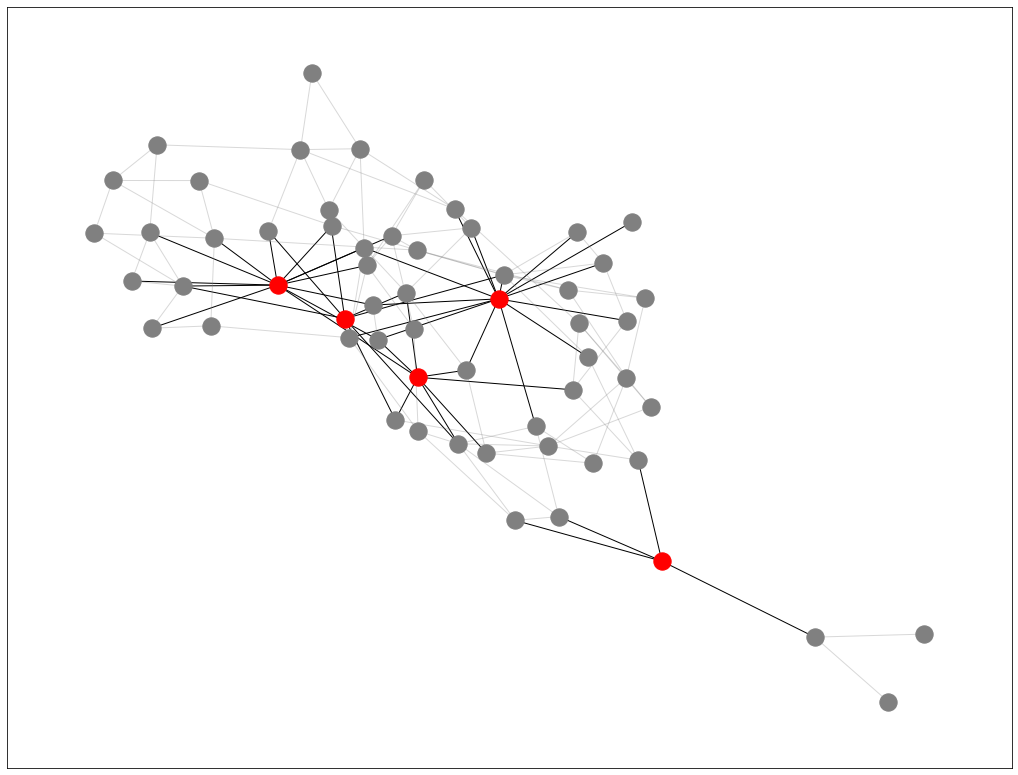

In [13]:
# split edges and nodes for drawing
removed_edges = [(i, j) for (i, j) in G.edges() if (i in critical_nodes or j in critical_nodes)]
remaining_edges = [(i, j) for (i, j) in G.edges() if (i, j) not in removed_edges]
remaining_nodes = [i for i in G.nodes() if i not in critical_nodes]
pos = nx.spring_layout(G, k=0.15)  # spring parameter k
plt.figure(figsize=[18, 14])
nx.draw_networkx_nodes(G, pos, nodelist=critical_nodes, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=remaining_nodes, node_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=removed_edges, edge_color='k')
nx.draw_networkx_edges(G, pos, edgelist=remaining_edges, edge_color='gray', alpha=0.3)
plt.show()

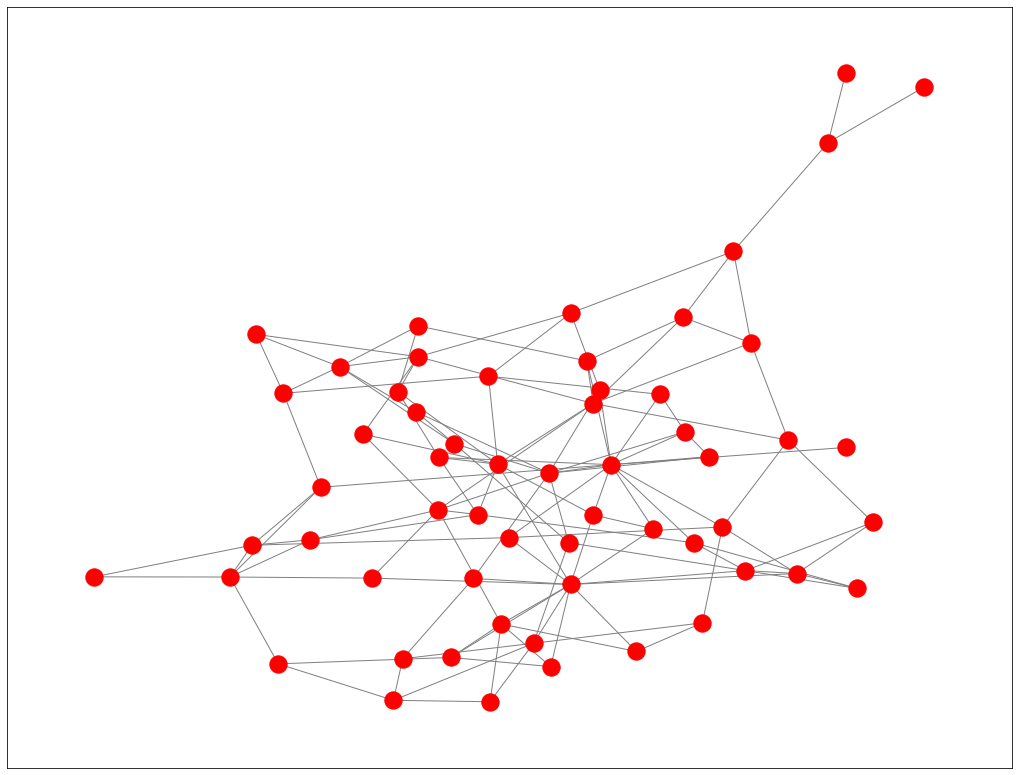

In [14]:
edges = [(i, j) for (i, j) in G.edges()]
nodes = [i for i in G.nodes()]
nodes.sort()
edges.sort()
pos = nx.spring_layout(G, k=0.15)  # spring parameter k
plt.figure(figsize=[18, 14])
nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='r')
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='gray')
plt.show()